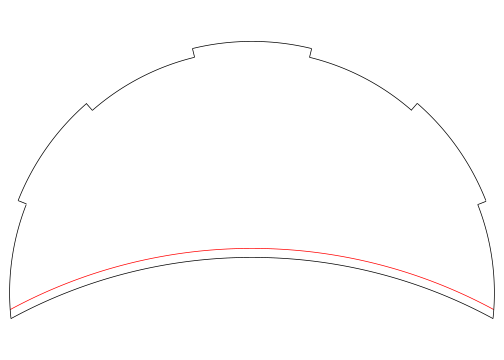

In [2]:
import drawSvg as draw
import math
from arc_calc import CircleArc

DRAWING_HEIGHT = 5
DRAWING_WIDTH = 7

d = draw.Drawing(DRAWING_WIDTH, DRAWING_HEIGHT, origin='center')
g = draw.Group(stroke_width=0.01, fill="none", stroke="black")

material_thickness = 1/8
gap = 0.125
paper_arc_length = 7
paper_arc_height = 0.85
top_height = 2.75


class PaperArc:
    length = paper_arc_length # Input
    height = paper_arc_height # Input
    arc_calc = CircleArc(sagitta=height, length=length).calc()
    radius = arc_calc['radius']
    width = arc_calc['chord']
    angle = math.degrees(arc_calc['angle'])
    
    
class InnerEdgeArc:
    height = paper_arc_height + top_height
    width = PaperArc.width
    radius = CircleArc(sagitta=height, chord=width).calc()['radius']
    arc_calc = CircleArc(radius=radius, sagitta=height + gap).calc()
    angle = math.degrees(arc_calc['angle'])
    length = arc_calc['length']
    width = arc_calc['chord']
    

class FaceArc:
    height = PaperArc.height
    arc_calc = CircleArc(chord=InnerEdgeArc.width, sagitta=paper_arc_height).calc()
    radius = arc_calc['radius']    
    length = arc_calc['length']
    width = arc_calc['chord']
    angle = math.degrees(arc_calc['angle'])

    
class OuterEdgeArc:
    radius = InnerEdgeArc.radius + material_thickness # Input
    height = InnerEdgeArc.height + material_thickness + gap # Input
    arc_calc = CircleArc(radius=radius, sagitta=height).calc()
    length = arc_calc['length']
    width =  arc_calc['chord']
    angle = math.degrees(arc_calc['angle'])

def hypotenuse_angle_to_base_height(hypotenuse, angle):
    base = hypotenuse * math.cos(math.radians(angle))
    height = hypotenuse * math.sin(math.radians(angle))
    return(base, height)
    
Y_OFFSET = -(PaperArc.radius - InnerEdgeArc.radius + top_height)

paper = draw.Path(stroke="red")
paper.arc(0, Y_OFFSET, PaperArc.radius, 
          90 - (PaperArc.angle / 2), 
          90 + (PaperArc.angle / 2))
g.append(paper)

Y_OFFSET = -(FaceArc.radius - InnerEdgeArc.radius + top_height + gap)
face = draw.Path()
face.arc(0, Y_OFFSET, FaceArc.radius, 
          90 - (FaceArc.angle / 2), 
          90 + (FaceArc.angle / 2))
g.append(face)

TAB_COUNT = 7
for i in range(TAB_COUNT):
    if i % 2 == 0:
        radius = InnerEdgeArc.radius
        joint_angle = InnerEdgeArc.angle / TAB_COUNT
    else:
        radius = OuterEdgeArc.radius
        joint_angle = OuterEdgeArc.angle / TAB_COUNT
        
    angle_start = 90 - joint_angle/2 + (joint_angle * (-(math.floor(TAB_COUNT/2)) + i))
    angle_end = 90 + joint_angle/2 + (joint_angle * (-(math.floor(TAB_COUNT/2)) + i))
    
    p = draw.Path()
    p.arc(0, 0, radius, angle_start, angle_end)
    g.append(p)

    if i < TAB_COUNT - 1:
        g.append(
            draw.Line(
                hypotenuse_angle_to_base_height(InnerEdgeArc.radius, angle_end)[0], 
                hypotenuse_angle_to_base_height(InnerEdgeArc.radius, angle_end)[1],
                hypotenuse_angle_to_base_height(OuterEdgeArc.radius, angle_end)[0], 
                hypotenuse_angle_to_base_height(OuterEdgeArc.radius, angle_end)[1], 
            )
        )

# Center the shape
g.args['transform'] = "translate(0 {})".format(
    -((OuterEdgeArc.height - OuterEdgeArc.radius) - 
      OuterEdgeArc.height/2)
)

d.append(g)

d.setPixelScale(72)
d.saveSvg('top_bottom.svg')
# Display in iPython notebook
d.rasterize()  # Display as PNG
d  # Display as SVG


0.9349679999999999


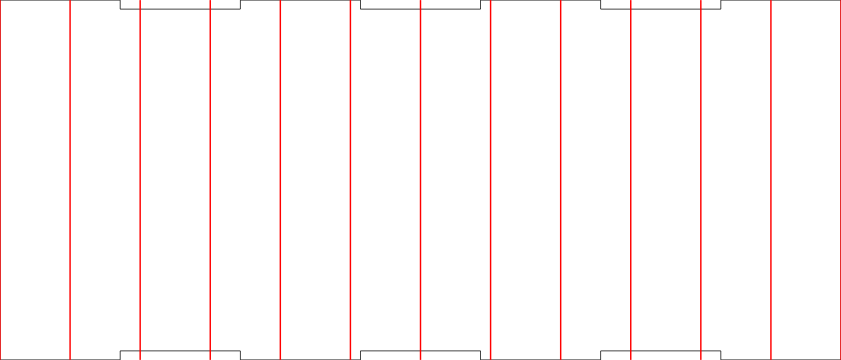

In [23]:
W = OuterEdgeArc.length
H = 5

d = draw.Drawing(W, H, origin=(0, 0))
g = draw.Group(stroke_width=0.01, fill="none", stroke="black")

g.extend([
    draw.Line(0, 0, 0, H),
    draw.Line(W, 0, W, H),
])

tab_width = W / TAB_COUNT
x_coord = 0
for i in range(TAB_COUNT):
    y_coord = H if i % 2 == 0 else H - material_thickness
    g.extend([
        draw.Line(x_coord, y_coord, x_coord + tab_width, y_coord),
        draw.Line(x_coord, H-y_coord, x_coord + tab_width, H-y_coord)
    ])

    x_coord += tab_width
    
    if i < TAB_COUNT - 1:
        g.extend([
            draw.Line(x_coord, H, x_coord, H - material_thickness),
            draw.Line(x_coord, 0, x_coord, material_thickness),
        ])

kerf_count = math.floor((OuterEdgeArc.radius - InnerEdgeArc.radius) / 0.01)
kerf_spacing = W / kerf_count
x_coord = 0
for i in range(kerf_count + 1):
    g.extend([
        draw.Line(x_coord, 0, x_coord, H, stroke="red", stroke_width=0.02),
    ])
    
    x_coord += kerf_spacing

d.append(g)
d.setPixelScale(72)
d.rasterize()